In [13]:
from temgymbasic import components as comp
from temgymbasic.model import Model
from temgymbasic.functions import make_test_sample, get_image_from_rays

import matplotlib.pyplot as plt
import numpy as np

Load the fourdstem_overfocused sample to use as comparison to temgymbasic's forward model. Note that I have zipped up the 4GB file that is created from this 4DSTEM result and it is available in the 
temgymbasic repo as a 50mb file - see the file "fourdstem_overfocused.zip". 

In [14]:
file = r"C:\Users\User\Documents\Code\src\temgymbasic\fourdstem_overfocused.npz"

fourdstem_overfocused = np.load(file)['arr_0']
sample = make_test_sample()

In [15]:
#Set number of detector pixels and detector size. For now keeping it simple 
#and assuming a square detector. 
detector_pixels = 256 #Detector pixels
detector_pixel_size = 0.000050 #pixel size in metres
detector_width = detector_pixels * detector_pixel_size #detector size

#We need to estimate the size of the sample in the sample plane,
#so we've used the scan pixel size and the number of pixels in the sample to do so.  
#If we want to sub sample the scan at a lower number of position while keeping the same sample size, 
#we can easily change the number of scan pixels later before running an experiment.
scan_pixels = sample.shape[0] #for now we match the number of pixels in the sample image
scan_pixel_size = 0.000001 #m
sample_width = scan_pixels * scan_pixel_size

#Set experiment parameters
camera_length = 0.15
overfocus = 0.001
semiconv = 0.020
scan_rotation = 0

In [16]:
#Create a list of components to model a simplified 4DSTEM experiment
components = [comp.DoubleDeflector(name = 'Scan Coils', z_up = 0.3, z_low = 0.25),
              comp.Lens(name = 'Lens', z = 0.20),
              comp.Sample(name = 'Sample', sample = sample, z = camera_length, width = sample_width),
              comp.DoubleDeflector(name = 'Descan Coils', z_up = 0.1, z_low = 0.05, scan_rotation = scan_rotation)
              ]

#Create the model Electron microscope. Initially we create a parallel circular beam leaving the "gun"
#where ~ 32000 rays can be used to view a sample image
model = Model(components, beam_z = 0.4, beam_type = 'paralell', num_rays = 2**15, 
              experiment = '4DSTEM', detector_pixels = detector_pixels, 
              detector_size = detector_width)

Now we run the first experiment, which is to try and recreate a single 4DSTEM image in the 
fourdstem_overfocused dataset obtained in the adjustment -- screen capture state.ipynb. Note we have performed this calculation with 0 scan rotation to simplify the comparison.

In [17]:
#Set the scan_pixel_size and scan_pixels of the model experiment
model.scan_pixel_size = scan_pixel_size

#Since the parameters such as overfocus and semi convergence angle are derived parameters from the settings
#of the components inside the electron microscope, we need to update the parameters of the model with the following functions
model.set_obj_lens_f_from_overfocus(overfocus)
model.set_beam_radius_from_semiconv(semiconv)

#For a basic circular beam use this function to make the model rays: note that the beam_type = 'parallel' initialised in the creation of the 
#model class triggers the creation of a circular beam (parallel is not a great name I know). The number of rays that fill this
#circular beam is defined by num_rays also initialised in the "Model" class. 
model.generate_rays()

#model.step() is where the matrix multiplication between the position matrix of each ray, stored in the variable (model.r),
#and the component transfer matrix occurs. 
_ = model.step()



Note below: model.r is the ray matrix that stores positions and slopes of each ray.
This matrix is of shape (steps, 5, num rays), where
steps is defined by the number of components. The middle shape index of 5 is so because each ray position matrix
is of shape (5, 1): [x, slope_x, y, slope_y, 1]. The 1 is neccessary at the end to facilitate the addition of a "slope"
to the ray which can be performed by a deflector component.
We can index the positions of rays at each component if we know the index of that component in the ray matrix.
We have created a special variable to index the ray positions of the sample called model.sample_r_idx

In [18]:

sample_rays_x = model.r[model.sample_r_idx, 0, :]
sample_rays_y = model.r[model.sample_r_idx, 2, :]

#Detector ray positions. Detector is always at the bottom, so -1 as the component index finds it's 
#ray positions.
detector_rays_x = model.r[-1, 0, :]
detector_rays_y = model.r[-1, 2, :]

#Function to obtain the sample_image
detector_ray_image, detector_sample_image, sample_pixel_coords, _ = get_image_from_rays(
    detector_rays_x, detector_rays_y,
    sample_rays_x, sample_rays_y,
    model.detector_size,
    model.detector_pixels,
    model.components[model.sample_idx].sample_size,
    model.components[model.sample_idx].sample_pixels,
    model.components[model.sample_idx].sample
)


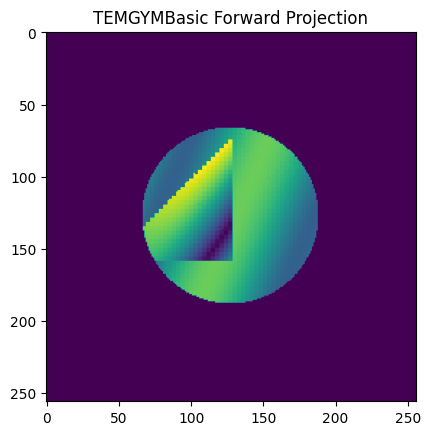

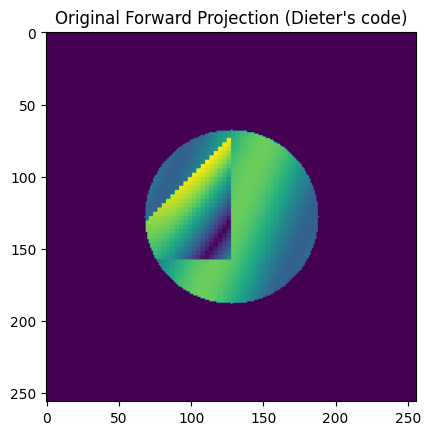

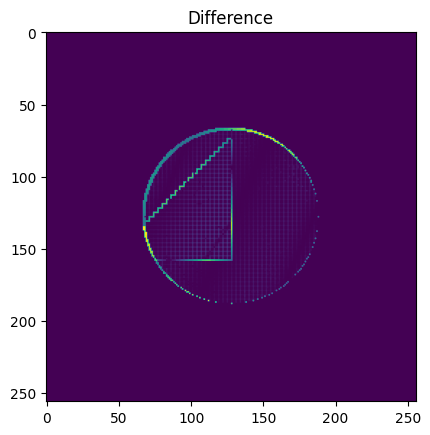

In [19]:
#Show results
plt.figure()
plt.title('TEMGYMBasic Forward Projection')
plt.imshow(detector_sample_image)

plt.figure()
plt.title('Original Forward Projection (Dieter\'s code)')
plt.imshow(fourdstem_overfocused[64, 64, :, :])

plt.figure()
plt.title('Difference')
plt.imshow(abs(fourdstem_overfocused[64, 64, :, :] - detector_sample_image))

Difference between two is nearly right, but it's not exact yet. This could be because of how my circular beam is created
which tries to evenly fill a radius with the chosen amount of rays, thus I may not be sampling the same pixels perfectly
like in Dieter's code. I also worry that there might be an accidental sampling error
of pixels in the sample (maybe rounding the ray coordinate to the nearest pixel is causing this). Will investigate further. 

To create a custom number of rays (say 3) with specific positions, we can use the following code. Note, that in order to
achieve the desired semi convergence angle before the sample, we have called the function
"model.set_beam_radius_from_semiconv" earlier, which will set the correct beam_radius at the "gun" (initial ray position)
. The beam radius this function finds should be used to 
set the outer radius of the ray bundle, which will achieve the desired semi_angle of the beam at crossover after the lens.

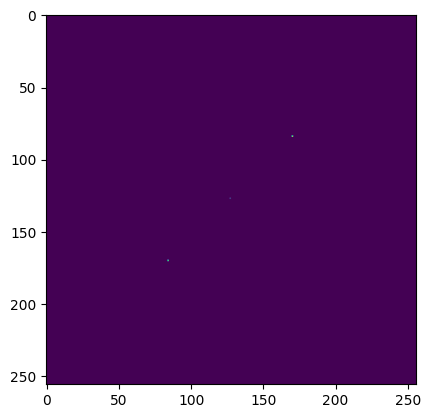

In [20]:
#Creation of the ray matrix which is of shape (steps in model, 5, number of rays)
model.r = np.zeros((model.steps, 5, 3))

#Due to how we have set up the model to add a deflection, the 5th entry in each
#ray matrix should be 1
model.r[:, 4, :] = np.ones(3)

#Create a ray that starts with a position of 45 degrees above the x-axis, and 
#a radius of the model.beam_radius that gives the desired semi convergence angle
model.r[:, 0, 1] = model.beam_radius*np.cos(np.pi/4) #x position
model.r[:, 2, 1] = model.beam_radius*np.sin(np.pi/4) #y position

#Create a ray that starts with a position of -135 degrees below the x-axis, and 
#a radius of the model.beam_radius that gives the desired semi convergence angle
model.r[:, 0, 2] = model.beam_radius*np.cos(-3*np.pi/4) #x position
model.r[:, 2, 2] = model.beam_radius*np.sin(-3*np.pi/4) #y position

#Note that this time we don't call model.generate_rays() because 
#that would overwrite out custom ray matrix of 3 rays
model.step()

sample_rays_x = model.r[model.sample_r_idx, 0, :]
sample_rays_y = model.r[model.sample_r_idx, 2, :]

detector_rays_x = model.r[-1, 0, :]
detector_rays_y = model.r[-1, 2, :]

detector_ray_image, detector_sample_image, sample_pixel_coords, _ = get_image_from_rays(
    detector_rays_x, detector_rays_y,
    sample_rays_x, sample_rays_y,
    model.detector_size,
    model.detector_pixels,
    model.components[model.sample_idx].sample_size,
    model.components[model.sample_idx].sample_pixels,
    model.components[model.sample_idx].sample
)

#Plot an image of 3 rays
plt.figure()
plt.imshow(detector_sample_image)


We can also plot a number of scan positions on the sample, to see which parts of the sample 
are projected forward to the detector

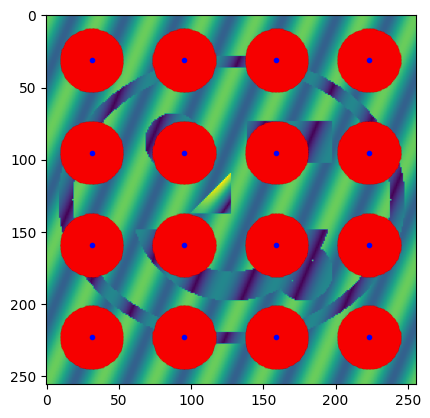

In [28]:
#We can set a lower amount of scan_pixels if we want to sample at a different spacing
model.scan_pixels = 4 #Determines number scan_pixels in one axis.
num_sample_positions = model.scan_pixels**2

#go back to the circular beam: 
model.generate_rays()

fig, ax = plt.subplots()

for _ in range(num_sample_positions):
    
    #We update the scan coil ratio to index the first scan position. This function
    #finds the deflector settings which will go through the beam pivot point that will perform perfect
    #beam_shift on the sample. Initial model.scan_pixel_x and model.scan_pixel_y are both 0, which means that the first beam 
    #position is in the top left corner of the sample
    model.update_scan_coil_ratio()
    model.step()
    
    #Obtain the scan position of the beam in pixel coordinates on the sample
    px_x = scan_pixels/(2*model.scan_pixels)+(model.scan_pixel_x/model.scan_pixels)*sample.shape[0]-1
    px_y = scan_pixels/(2*model.scan_pixels)+(model.scan_pixel_y/model.scan_pixels)*sample.shape[0]-1

    #Move to the next scan position
    model.update_scan_position()
    
    sample_rays_x = model.r[model.sample_r_idx, 0, :]
    sample_rays_y = model.r[model.sample_r_idx, 2, :]
    
    #Detector ray positions
    detector_rays_x = model.r[-1, 0, :]
    detector_rays_y = model.r[-1, 2, :]
    
    #Create detector image of rays: get_image_from_rays converts sample and detector positions 
    #to sample and detector coordinates
    detector_ray_image, detector_sample_image, sample_pixel_coords, _ = get_image_from_rays(
        detector_rays_x, detector_rays_y,
        sample_rays_x, sample_rays_y,
        model.detector_size,
        model.detector_pixels,
        model.components[model.sample_idx].sample_size,
        model.components[model.sample_idx].sample_pixels,
        model.components[model.sample_idx].sample
    )
    
    #Plot the beam pixel coordinates on the sample to see which part of the sample we are imaging. 
    ax.plot(sample_pixel_coords[:, 1], sample_pixel_coords[:, 0], '.r', alpha = 0.1, zorder = 1)
    ax.plot(px_y, px_x, '.b', zorder = 2)

ax.imshow(sample, zorder = 0)
plt.show()
